In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.stats as st
import multiprocessing as mp

#Save
import json, h5py
import scipy.io as sio
import io_dict_to_hdf5 as ioh5

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#User
import util
import plotting as usrplt
import decoding as dc



In [5]:
#Read in cross-validation parameters
# BaseDir = './results/sticky-ARHMM_lag-1_dsf-2_kappa-1e+07_2020-11-15_1437'
BaseDir = './results/sticky-ARHMM_lag-1_dsf-2_kappa-5e+06_2020-11-15_2033'
with open(os.path.join(BaseDir,'ARHMM_hyperparameters.json')) as json_file:
    opt = json.load(json_file)
opt

{'save': 1,
 'mID': 'all_mice',
 'downsample_factor': 2,
 'model_type': 'ARHMM',
 'transitions': 'sticky',
 'observations': 'autoregressive',
 'inputdriven': 0,
 'Kmin': 6,
 'Kmax': 16,
 'kappa': 5000000.0,
 'AR_lags': 1,
 'MAP_threshold': 0.75,
 'EM_tolerance': 1e-06,
 'EM_iters': 200,
 'xval_type': 'K',
 'kXval': 2,
 'max_processes': 15,
 'SaveDirRoot': '/home/dwyrick/projects/jumping_behavior/results/sticky-ARHMM_lag-1_dsf-2_kappa-5e+06_2020-11-15_2033'}

In [3]:
##===== Read in data at downsample factor =====##
data_list, mask_list, data_df = util.read_data(dsf=opt['downsample_factor'])

##===== Read in data at downsample factor =====##
data_fullres_list, _, _ = util.read_data(dsf=1)

In [4]:
#Set abort trials to failure trials
data_df.loc[data_df['success'] == 2,'success'] = 0

#Set "opto suture" trials where there was no optogenetics performed to "suture" trials
data_df.loc[(data_df['laser_trial'] == 'laser off') & (data_df['condition'] == 'opto suture'),'condition'] = 'suture'

#Print
data_df.head()

,expdate,subject,condition,platform,distance,success,laser_trial,jump_time,trial,fps,...,Side LEar y,Top LEar y,Side LEar likelihood,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood
0,061920,J157BLT,control,2,8,0,laser off,125,1,60,...,"[425.385317744935, 366.33104528399747, 307.276...","[410.1932973761308, 352.0100881476151, 293.743...","[0.9999992847442627, 0.9999996423721313, 0.999...","[0.9999997615814209, 0.9999998807907104, 0.999...","[343.8412719726563, 458.4371704101562, 573.033...","[314.5657470703125, 419.42099609375003, 524.27...","[449.0091425115412, 384.95652410333804, 320.90...","[401.4983811248759, 342.47820290221966, 283.45...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0..."
1,061920,J157BLT,control,1,20,0,laser off,222,2,60,...,"[433.1472437062976, 376.13851567895387, 319.12...","[410.46880031185265, 353.5964736516964, 296.65...","[0.9999973773956299, 0.9999958276748657, 0.999...","[0.9999992847442627, 0.9999996423721313, 0.999...","[343.52678222656255, 458.06650390625003, 572.6...","[312.7005615234375, 416.93408203125, 521.16760...","[447.5615396573399, 383.70670567296486, 319.85...","[404.90802086255826, 346.7887886848239, 288.66...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0..."
2,061920,J157BLT,control,3,8,1,laser off,355,3,60,...,"[407.3741518887608, 348.01848782626075, 288.58...","[361.26440623890267, 306.1514179576527, 251.19...","[0.9999998807907104, 0.9999998807907104, 0.999...","[0.9999997615814209, 0.9999997615814209, 0.999...","[343.5391479492188, 457.974072265625, 572.3549...","[314.574169921875, 419.43222656250003, 524.290...","[446.51506847034796, 382.5187916148792, 318.38...","[402.4329915364583, 344.60011800130206, 286.76...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630..."
3,061920,J157BLT,control,1,12,1,laser off,514,4,60,...,"[426.17190549660387, 369.09125364113515, 311.7...","[375.1970238334944, 319.0105187065413, 262.857...","[0.9999997615814209, 0.9999995231628418, 0.999...","[0.9999972581863403, 0.9999987483024597, 0.999...","[343.9951171875, 458.68979492187503, 573.36568...","[315.40451660156253, 420.53935546875005, 525.6...","[448.9589674068071, 385.0646436763384, 321.142...","[405.64251222127933, 347.9299939107325, 290.21...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0..."
4,061920,J157BLT,control,2,12,0,laser off,651,5,60,...,"[429.43573380136877, 369.31512833261877, 308.8...","[354.6358043391531, 299.05050770829365, 243.60...","[1.0, 0.9999998807907104, 0.9999995231628418, ...","[0.9999991655349731, 0.9999986886978149, 0.999...","[343.91730957031257, 458.74045410156253, 573.5...","[313.2942993164063, 417.3133544921875, 521.236...","[446.6510607711668, 382.556981181323, 318.4961...","[403.01506375902665, 345.44733914965167, 287.8...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827..."


In [6]:
K = 12
SaveDir = os.path.join(BaseDir,'K-{:0d}'.format(K))
fname_sffx = 'sARHMM_lag-{}_K-{:02d}_dsf-{}_Kappa-{:.0e}'.format(opt['AR_lags'],K,opt['downsample_factor'],opt['kappa'])

#Load MAP sequence results
fpath = glob(os.path.join(SaveDir,'MAP_seqs*.h5'))[0]
trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [48]:
#Load MAP sequence results
fpath = glob(os.path.join(SaveDir,'MAP_seqs*.h5'))[0]
trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

trMasks2 = []
tBins_removed = []
for iTrial, mapseq in enumerate(trMAPs):
    #Apply posterior probability threshold mask
    MAPcp = mapseq.copy()
    mask = trMasks[iTrial]
    MAPcp[~mask] = -1

    #Loop over states and NaN out that were less than 100ms (3 frames)
    for state in range(K):
        state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
        state_trans = np.diff(state_1hot)
        state_ends = np.nonzero(state_trans == -1)[0]
        state_starts = np.nonzero(state_trans == +1)[0]
        state_durations = state_ends - state_starts

        #State was not used this trial
        if len(state_durations) == 0:
            continue

        #Loop over the individual state sequences and NaN out the short ones
        for iSeq, sd in enumerate(state_durations):
            if sd <= 3:
                MAPcp[slice(state_starts[iSeq],state_ends[iSeq])] = -1

    #Update mask
    mask2 = MAPcp != -1
    trMasks2.append(mask2)

    #See how much of a difference that made
    tBins_removed.append(np.sum(mask)-np.sum(mask2))

        
        
            
            
    

/home/dwyrick/projects/jumping_behavior/io_dict_to_hdf5.py:66: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  ans[key] = item.value


In [50]:
np.sum(tBins_removed)


8862

In [42]:
mask2


array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 19, 20, 21, 22, 23, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 40, 41, 42, 43, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67,
       68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98])

In [8]:
TCMs = util.get_transition_count_matrices(trMAPs,trMasks,K,normalize=True)
TPM = np.exp(arhmm_params['transitions']['log_Ps'])

## Calculate state duration and state usage 
state_duration_list, state_startend_list, mean_state_durations, state_usage_pertrial, state_usage = util.get_state_durations(trMAPs, trMasks, K)

In [9]:
TCMs.shape

(4310, 12, 12)

In [10]:
indy_dict = data_df.groupby(['subject','distance','success']).indices
mouse_IDs = np.unique(data_df['subject'])
distances = np.unique(data_df['distance'])

for mID in mouse_IDs:
    print('\nMouse: {}'.format(mID))
    for dist in distances:
        print('\nDistance: {}->'.format(dist),end='\t')
        for success in range(3):
            if (mID,dist,success) in indy_dict.keys():
                nTrials = len(indy_dict[mID,dist,success])
            else:
                nTrials = 0
            print('{}: {:3d} trials'.format(success,nTrials),end='\t')
            


Mouse: J157BLT

Distance: 8->	0:   2 trials	1:  63 trials	2:   0 trials	
Distance: 12->	0:   6 trials	1:  60 trials	2:   0 trials	
Distance: 16->	0:  10 trials	1:  52 trials	2:   0 trials	
Distance: 20->	0:  15 trials	1:  47 trials	2:   0 trials	
Distance: 24->	0:  42 trials	1:  19 trials	2:   0 trials	
Mouse: J157BRT

Distance: 8->	0:   6 trials	1: 105 trials	2:   0 trials	
Distance: 12->	0:  11 trials	1: 106 trials	2:   0 trials	
Distance: 16->	0:  16 trials	1: 104 trials	2:   0 trials	
Distance: 20->	0:  26 trials	1:  94 trials	2:   0 trials	
Distance: 24->	0:  68 trials	1:  49 trials	2:   0 trials	
Mouse: J158BLT

Distance: 8->	0:   1 trials	1:  93 trials	2:   0 trials	
Distance: 12->	0:   4 trials	1:  91 trials	2:   0 trials	
Distance: 16->	0:   5 trials	1:  90 trials	2:   0 trials	
Distance: 20->	0:  13 trials	1:  80 trials	2:   0 trials	
Distance: 24->	0:  49 trials	1:  43 trials	2:   0 trials	
Mouse: J158BRT

Distance: 8->	0:   0 trials	1:  93 trials	2:   0 trials	
Distance: 1

In [11]:
mID = 'J158BLT'
dist = 24

indy_dict = data_df.groupby(['subject','distance','success']).indices
#Get "Failure" trials
indy = indy_dict[(mID,dist,0)]
nTrials_0 = len(indy)
failure_TCMs = TCMs[indy].reshape(nTrials_0,-1)

#Get "Success" trials
indy = indy_dict[(mID,dist,1)]
nTrials_1 = len(indy)
success_TCMs = TCMs[indy].reshape(nTrials_1,-1)

nTrials_match = np.min([nTrials_0,nTrials_1])
trial_indices = np.concatenate((indy_dict[(mID,dist,0)][:nTrials_match],indy_dict[(mID,dist,1)][:nTrials_match]))

In [12]:
tmp_dict = data_df.iloc[trial_indices].groupby(['condition','success']).indices

for key in tmp_dict.keys():
    print('{}: {} trials'.format(key,len(tmp_dict[key])))

('control', 0): 34 trials
('control', 1): 30 trials
('opto suture', 0): 1 trials
('opto suture', 1): 3 trials
('suture', 0): 8 trials
('suture', 1): 10 trials


In [121]:
print('Test: {:e}'.format(1E6))


Test: 1.000000e+06


In [14]:
##===== Put in form for decoding analysis =====##
X = np.vstack((failure_TCMs[:nTrials_match],success_TCMs[:nTrials_match]))
Y = np.concatenate((np.repeat(0,nTrials_match),np.repeat(1,nTrials_match)))

Y_sort = ['{}_{}'.format(data_df.iloc[iT]['condition'],data_df.iloc[iT]['success']) for iT in trial_indices]


/home/dwyrick/miniconda3/envs/ssm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


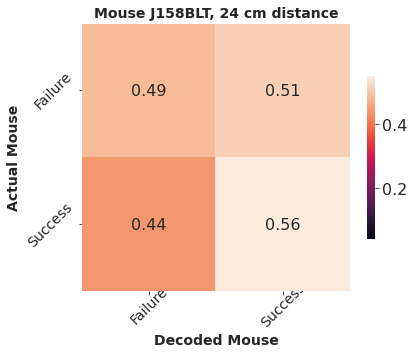

In [16]:
classifier = 'LDA'
method='kfold'

## Try to decode whether the animal was successful or not based on the transition count matrices
confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],nKfold=5,classifier=classifier,method=method)

#Plot decoding performance 
title = 'Mouse {}, {} cm distance'.format(mID,dist)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['Failure','Success'],title=title)

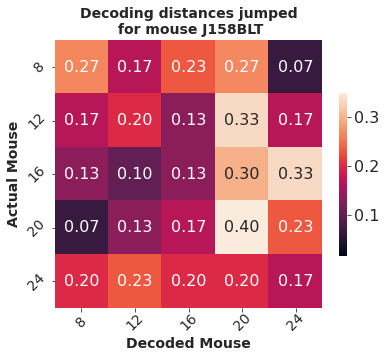

In [17]:
##Can we decode different distances successfully jumped within the same mouse?
indy_dict = data_df.groupby(['subject','condition','distance','success']).indices
nTrials_match = np.min([len(indy_dict[(mID,'control',d,1)]) for d in distances])

indy_list = []
for d in distances:
    indy_list.append(indy_dict[(mID,'control',d,1)][:nTrials_match])
trial_indices = np.concatenate(indy_list)

X = TCMs[trial_indices].reshape(len(trial_indices),-1)
Y = np.concatenate([np.repeat(d,nTrials_match) for d in distances])

classifier = 'LDA'
method='kfold'

## Try to decode whether the animal was successful or not based on the transition count matrices
confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,clabels=distances,nKfold=5,classifier=classifier,method=method)

#Plot decoding performance 
title = 'Decoding distances jumped\n for mouse {}'.format(mID)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=distances,title=title)

In [23]:
6/30

0.2

In [116]:
indy_dict = data_df.groupby(['subject','condition','distance','success']).indices

mTrials_list = []
#Match nTrials for each distance across mice
for d in distances:
    tmp_list = []
    for mID in mouse_IDs:
        tmp_list.append(len(indy_dict[(mID,'control',d,1)]))
    mTrials_list.append(np.min(tmp_list))
mTrials_list

indy_list = []
for mID in mouse_IDs:
    ii = 2; d = 16
#     for ii,d in enumerate(distances):
    nTrials_match = mTrials_list[ii]
    indy_list.append(indy_dict[(mID,'control',d,1)][:nTrials_match])
trial_indices = np.concatenate(indy_list)

np.unique(data_df.iloc[trial_indices]['subject'],return_counts=True)


X = TCMs[trial_indices].reshape(len(trial_indices),-1)
Y = data_df.iloc[trial_indices]['subject'].values

Y_sort = ['{}_{}'.format(data_df.iloc[iT]['subject'],data_df.iloc[iT]['distance']) for iT in trial_indices]

In [ ]:
classifier = 'LDA'
method='kfold'

## Try to decode whether the animal was successful or not based on the transition count matrices
confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=mouse_IDs,nKfold=10,classifier=classifier,method=method)

In [108]:
len(mouse_IDs)

8

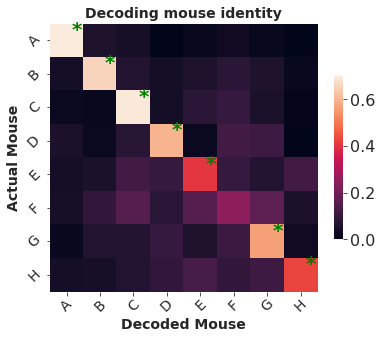

In [112]:
#Plot decoding performance 
title = 'Decoding mouse identity'
dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D','E','F','G','H'],annot=False,title=title)

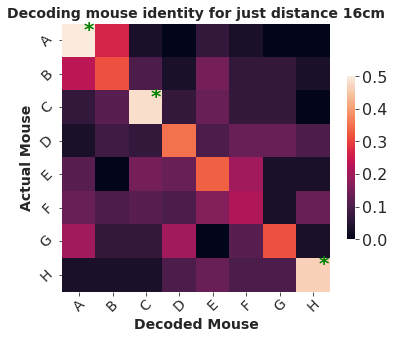

In [117]:
classifier = 'LDA'
method='kfold'

## Try to decode whether the animal was successful or not based on the transition count matrices
confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=mouse_IDs,nKfold=10,classifier=classifier,method=method)

#Plot decoding performance 
title = 'Decoding mouse identity for just distance 16cm'
dc.plot_decoding_accuracy(confusion_mat,confusion_z,class_labels=['A','B','C','D','E','F','G','H'],annot=False,title=title)